In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm 

In [2]:
def expected_improvement(prediction, standard_dev, best):
    z = (-abs(1.7-prediction)+abs(1.7-best))/standard_dev
    return (-abs(1.7-prediction)+abs(1.7-best))*norm.cdf(z) + standard_dev*norm.pdf(z)

def probability_of_improvement(prediction, standard_dev, best):
    z = (-abs(1.7-prediction)+abs(1.7-best))/standard_dev
    return norm.cdf(z)


In [3]:
oer_desc_data = pickle.load(open("racs_and_desc/data_mc3_lc0.p", "rb"))

oer_desc_vals = []
racs = []
catalyst_names = []

for name in oer_desc_data:
    oer_desc_vals.append(oer_desc_data[name][0])
    racs.append(oer_desc_data[name][1])
    catalyst_names.append(name)

In [4]:
def bayes_opt_test(substring_list, opt_val, ei=True):
    holdout_racs = [racs[idx] for idx, cat_name in enumerate(catalyst_names) if any(substring in cat_name for substring in substring_list)] 
    holdout_oh = [oer_desc_vals[idx] for idx, cat_name in enumerate(catalyst_names) if any(substring in cat_name for substring in substring_list)]
    holdout_names = [catalyst_names[idx] for idx, cat_name in enumerate(catalyst_names) if any(substring in cat_name for substring in substring_list)]

    train_racs = [racs[idx] for idx, cat_name in enumerate(catalyst_names) if not any(substring in cat_name for substring in substring_list)]
    train_oh = [oer_desc_vals[idx] for idx, cat_name in enumerate(catalyst_names) if not any(substring in cat_name for substring in substring_list)]
    train_names = [catalyst_names[idx] for idx, cat_name in enumerate(catalyst_names) if not any(substring in cat_name for substring in substring_list)]
    
    len2return = len(holdout_oh)
    best_prediction = 0
    preds_added = []
    good_or_bad = []
    distance_to_best = []
    best_dist_so_far = 10

    target = np.min(abs(np.asarray(holdout_oh) - opt_val))
    target_oh = holdout_oh[np.argmin(abs(np.asarray(holdout_oh) - opt_val))]
    
    cumulative_reg = 0
    cumulative_regret = []
    cumulative_regret_vals = []
    while len(holdout_oh)>0:
        moving_target_oh = holdout_oh[np.argmin(abs(np.asarray(holdout_oh) - opt_val))]
        sc = StandardScaler()
        scaled_X_train = sc.fit_transform(train_racs)
        scaled_X_test = sc.transform(holdout_racs)

        kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e3))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=.01, n_restarts_optimizer=20)
        gp.fit(scaled_X_train, train_oh)

        preds, stds = gp.predict(scaled_X_test, return_std=True)
        if ei:
            acq_fun_vec = [expected_improvement(x, y, best_prediction) for x, y in zip(preds, stds)]
        else:
            acq_fun_vec = [probability_of_improvement(x, y, best_prediction) for x, y in zip(preds, stds)]

        recommend_next = holdout_names[np.argmax(acq_fun_vec)]
        #print(recommend_next)
        oh_val = holdout_oh[np.argmax(acq_fun_vec)]
        if abs(opt_val-oh_val) < abs(opt_val-best_prediction):
            best_prediction = oh_val

        if abs(abs(opt_val-oh_val)-target)<best_dist_so_far:
            best_dist_so_far = abs(abs(opt_val-oh_val)-target)
        distance_to_best.append(best_dist_so_far)

        if abs(1.7-oh_val) < np.mean(abs(np.asarray(holdout_oh) - opt_val)):
            good_or_bad.append(1)
        else:
            good_or_bad.append(0)
        
        cumulative_reg += abs(moving_target_oh-oh_val)
        cumulative_regret.append(cumulative_reg)
        cumulative_regret_vals.append(abs(moving_target_oh-oh_val))
        plt
        train_racs.append(holdout_racs[np.argmax(acq_fun_vec)])
        train_oh.append(holdout_oh[np.argmax(acq_fun_vec)])
        train_names.append(holdout_names[np.argmax(acq_fun_vec)])
        preds_added.append(abs(holdout_oh[np.argmax(acq_fun_vec)]-opt_val))
        del holdout_racs[np.argmax(acq_fun_vec)]
        del holdout_oh[np.argmax(acq_fun_vec)]
        del holdout_names[np.argmax(acq_fun_vec)]
    
    return distance_to_best, good_or_bad, len2return, cumulative_regret
    



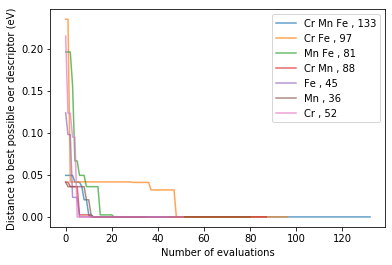

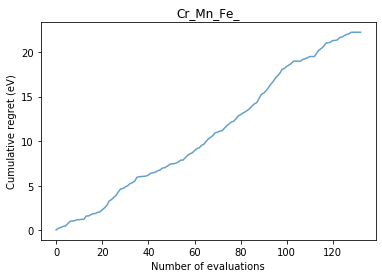

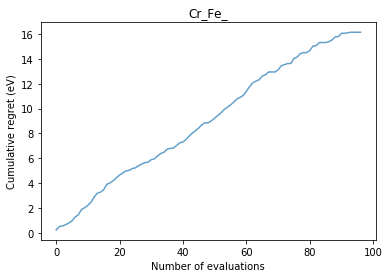

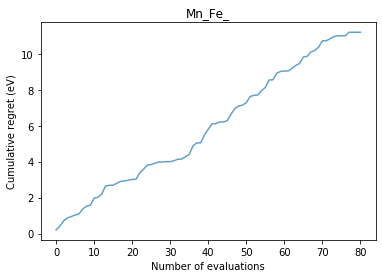

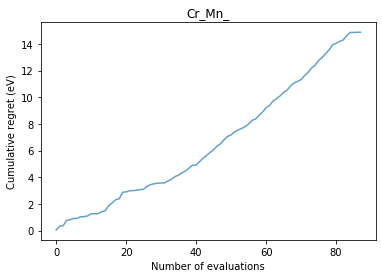

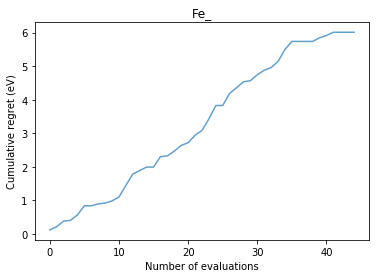

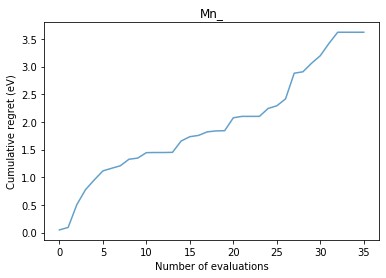

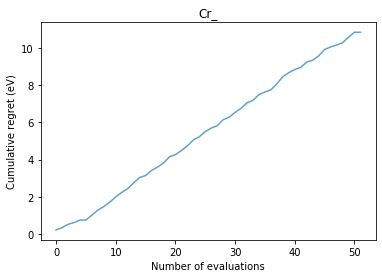

<Figure size 432x288 with 0 Axes>

In [5]:
# get 2 convergence warnings for some GPR training iterations but can be ignored
import warnings
warnings.filterwarnings('ignore')

holdout_sets = [["Cr", "Mn", "Fe"], ["Cr", "Fe"], ["Mn", "Fe"], ["Cr", "Mn"], ["Fe"], ["Mn"], ["Cr"]]

ret_dists = []
cumulative_regrets = []
total_lens = []
for holdout in holdout_sets:
    ret_dist, good_or_bad, len_returned, cumul_regret = bayes_opt_test(holdout, 1.7)
    ret_dists.append(ret_dist)
    cumulative_regrets.append(cumul_regret)
    total_lens.append(len_returned)

count =0 
for ret_dist, total_len in zip(ret_dists, total_lens):
    label_str = ""
    for metal in holdout_sets[count]:
        label_str+=metal+" "
    label_str += ", {}".format(total_len)
    plt.plot(ret_dist, label=label_str, alpha=1.7)
    count+=1
plt.legend()
plt.xlabel("Number of evaluations")
plt.ylabel("Distance to best possible oer descriptor (eV)")
plt.savefig("convergence_ei.pdf")
plt.show()
count = 0 
for cumul_regret in cumulative_regrets:
    label_str = ""
    for metal in holdout_sets[count]:
        label_str+=metal+"_"
    plt.plot(cumul_regret, alpha=1.7)
    plt.xlabel("Number of evaluations")
    plt.ylabel("Cumulative regret (eV)")
    plt.title(label_str)
    plt.show()
    plt.savefig("{}_cumulative_reg_ei.pdf".format(label_str))
    count+=1


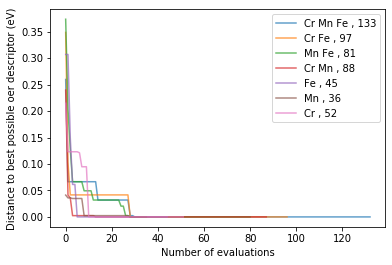

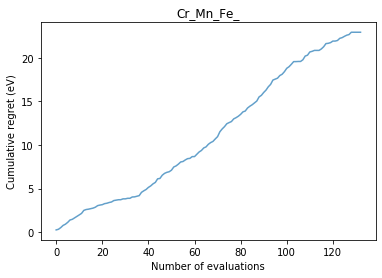

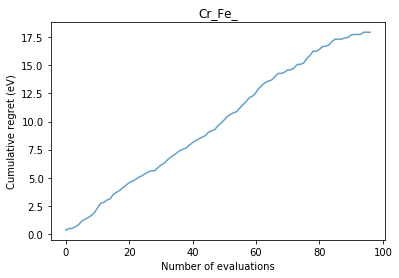

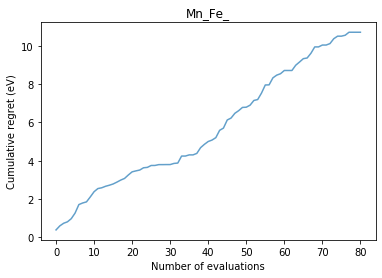

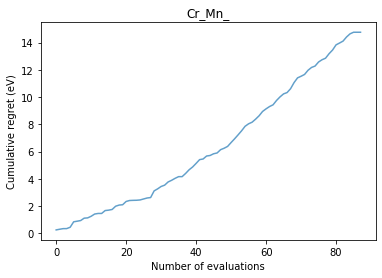

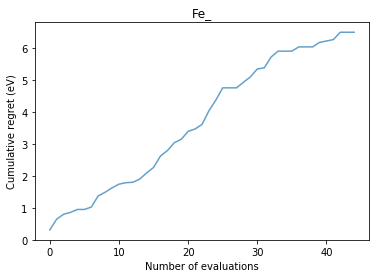

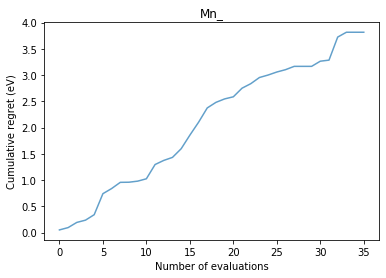

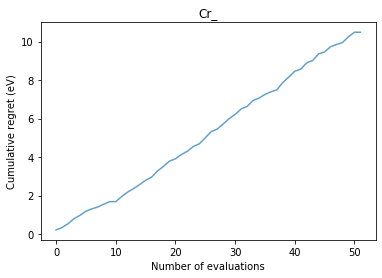

In [6]:
ret_dists = []
cumulative_regrets = []
total_lens = []
for holdout in holdout_sets:
    ret_dist, good_or_bad, len_returned, cumul_regret = bayes_opt_test(holdout, 1.7, ei=False)
    ret_dists.append(ret_dist)
    cumulative_regrets.append(cumul_regret)
    total_lens.append(len_returned)

count =0 
for ret_dist, total_len in zip(ret_dists, total_lens):
    label_str = ""
    for metal in holdout_sets[count]:
        label_str+=metal+" "
    label_str += ", {}".format(total_len)
    plt.plot(ret_dist, label=label_str, alpha=1.7)
    count+=1
plt.legend()
plt.xlabel("Number of evaluations")
plt.ylabel("Distance to best possible oer descriptor (eV)")
plt.savefig("convergence_pi.pdf")
plt.show()
count = 0 
for cumul_regret in cumulative_regrets:
    label_str = ""
    for metal in holdout_sets[count]:
        label_str+=metal+"_"
    plt.plot(cumul_regret, alpha=1.7)
    plt.xlabel("Number of evaluations")
    plt.ylabel("Cumulative regret (eV)")
    plt.title(label_str)
    plt.savefig("{}_cumulative_reg_pi.pdf".format(label_str))
    plt.show()
    count+=1

